# Downloading Market and Fundamental Data with `yfinance`

## Imports & Settings

In [15]:
import pandas as pd
import yfinance as yf

In [34]:
data = yf.download(
        tickers = "SPY AAPL MSFT", # list or string

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5d",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "60m",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  3 of 3 completed


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2024-04-08 04:00:00 to 2024-04-12 19:00:00
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (SPY, Open)     85 non-null     float64
 1   (SPY, High)     85 non-null     float64
 2   (SPY, Low)      85 non-null     float64
 3   (SPY, Close)    85 non-null     float64
 4   (SPY, Volume)   85 non-null     int64  
 5   (MSFT, Open)    85 non-null     float64
 6   (MSFT, High)    85 non-null     float64
 7   (MSFT, Low)     85 non-null     float64
 8   (MSFT, Close)   85 non-null     float64
 9   (MSFT, Volume)  85 non-null     int64  
 10  (AAPL, Open)    85 non-null     float64
 11  (AAPL, High)    85 non-null     float64
 12  (AAPL, Low)     85 non-null     float64
 13  (AAPL, Close)   85 non-null     float64
 14  (AAPL, Volume)  85 non-null     int64  
dtypes: float64(12), int64(3)
memory usage: 10.6 KB


In [38]:
# auto_adjust = True
data['SPY']

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-04-08 04:00:00,518.830000,519.070000,517.03000,517.660000,0
2024-04-08 05:00:00,517.610000,518.480000,517.47000,518.300000,0
2024-04-08 06:00:00,518.310000,518.350000,517.85000,518.300000,0
2024-04-08 07:00:00,518.330000,518.940000,518.04000,518.560000,0
2024-04-08 08:00:00,518.560000,519.240000,517.45990,519.160000,0
...,...,...,...,...,...
2024-04-12 15:30:00,509.494995,510.920013,509.26001,510.820007,14383801
2024-04-12 16:00:00,510.830000,518.745000,483.07056,510.690000,0
2024-04-12 17:00:00,510.850000,510.850000,510.40000,510.479200,0


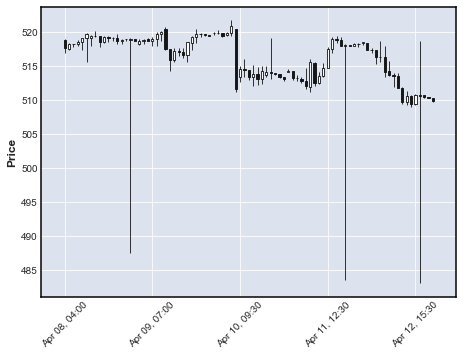

In [41]:
# plot the candlesticks for SPY
import mplfinance as mpf
mpf.plot(data['SPY'], type='candle')


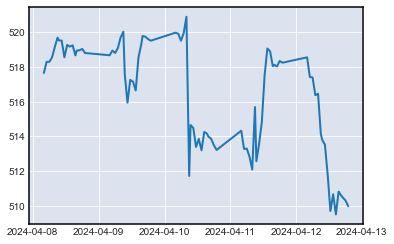

In [42]:
import matplotlib.pyplot as plt
plt.plot(data['SPY']['Close'])